# Part 3: Analysis

In [34]:
import pandas as pd
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
file_path = os.path.join(project_root, 'data', 'output', 'sentiment_data.csv')

df_news = pd.read_csv(file_path, encoding='utf-8-sig')
df_news["date"] = pd.to_datetime(df_news["date"])
df_news = df_news.set_index("date")

# 移除 title 欄位重複的資料，預設保留第一筆 (keep='first')
df_news = df_news.drop_duplicates(subset=['title'], keep='first')



# 檢查一下結果
print(f"剩餘資料筆數: {len(df_news)}")


剩餘資料筆數: 2024


In [35]:
# 1. 確保時間格式正確 (重要！請轉成 UTC)
df_news.index = pd.to_datetime(df_news.index, utc=True)
df_news['Count_Neg'] = (df_news['Sentiment_Label'] == 0).astype(int)
df_news['Count_Pos'] = (df_news['Sentiment_Label'] == 2).astype(int)

# 2. 設定聚合頻率
agg_freq = 'D'

# 3. 執行聚合
df_sentiment_agg = df_news.resample(agg_freq).agg({
    'Sentiment_Score': ['mean', 'std', 'count', 'min', 'max'],
    'Count_Pos': 'sum',                 # 新增：每日利多篇數
    'Count_Neg': 'sum'                  # 新增：每日利空篇數
})

# 3. 整理欄位名稱
df_sentiment_agg.columns = ['Avg_Sentiment', 'Std_Sentiment', 'News_Volume', 'Min_Score', 'Max_Score', 'Count_Pos', 'Count_Neg']

# 4. 填補空值
df_sentiment_agg = df_sentiment_agg.fillna(0)

print(f"📊 聚合完成，共 {len(df_sentiment_agg)} 筆時間序列資料")
print(df_sentiment_agg.head(5))

📊 聚合完成，共 30 筆時間序列資料
                           Avg_Sentiment  Std_Sentiment  News_Volume  \
date                                                                   
2025-11-13 00:00:00+00:00      -0.158547       0.483449           49   
2025-11-14 00:00:00+00:00       0.038092       0.367453           20   
2025-11-15 00:00:00+00:00      -0.055438       0.553500           85   
2025-11-16 00:00:00+00:00      -0.081342       0.508148           61   
2025-11-17 00:00:00+00:00       0.043464       0.577456           66   

                           Min_Score  Max_Score  Count_Pos  Count_Neg  
date                                                                   
2025-11-13 00:00:00+00:00  -0.970488   0.885715          4         15  
2025-11-14 00:00:00+00:00  -0.857741   0.906304          2          3  
2025-11-15 00:00:00+00:00  -0.967008   0.976522         18         24  
2025-11-16 00:00:00+00:00  -0.966023   0.942930          8         17  
2025-11-17 00:00:00+00:00  -0.964688   0.97

In [61]:
import pandas as pd
import numpy as np

def prepare_sentiment_for_trading(df):
    # 1. 建立副本
    df = df.copy()

    # ---------------------------
    # A. 處理日期與目標交易日
    # ---------------------------
    df['weekday'] = df.index.dayofweek
    df['Target_Date'] = df.index + pd.Timedelta(days=1)

    # 修正週末：週五/週六 指向 下週一
    mask_fri = (df['weekday'] == 4)
    mask_sat = (df['weekday'] == 5)
    df.loc[mask_fri, 'Target_Date'] = df.index[mask_fri] + pd.Timedelta(days=3)
    df.loc[mask_sat, 'Target_Date'] = df.index[mask_sat] + pd.Timedelta(days=2)

    # ---------------------------
    # B. 準備加權平均 (Vectorized Approach)
    # ---------------------------
    df['Sentiment_Mass'] = df['Avg_Sentiment'] * df['News_Volume']

    # ---------------------------
    # C. 聚合 (Aggregation) - 加入 Count_Pos 與 Count_Neg
    # ---------------------------
    df_grouped = df.groupby('Target_Date').agg({
        'Sentiment_Mass': 'sum',
        'News_Volume': 'sum',
        'Std_Sentiment': 'max',
        'Count_Pos': 'sum',            # [新增] 週末三天的利多總和
        'Count_Neg': 'sum'             # [新增] 週末三天的利空總和
    })

    # ---------------------------
    # D. 計算衍生指標
    # ---------------------------
    # 1. 恢復加權平均分數
    df_grouped['Avg_Sentiment'] = df_grouped.apply(
        lambda row: row['Sentiment_Mass'] / row['News_Volume'] if row['News_Volume'] > 0 else 0,
        axis=1
    )

    # 2. [重點] 計算 Bullish Ratio (利多 / (利多 + 利空))
    # 公式：Pos / (Pos + Neg)
    # 範圍：0 (極空) ~ 1 (極多)。若分母為 0 (當天無多空新聞)，設為 0.5 (中立)
    df_grouped['Bullish_Ratio'] = df_grouped.apply(
        lambda row: row['Count_Pos'] / (row['Count_Pos'] + row['Count_Neg'])
        if (row['Count_Pos'] + row['Count_Neg']) > 0 else 0.5,
        axis=1
    )

    # 移除暫存欄位 (Sentiment_Mass 已經用完，Count 欄位看你想不想保留，這裡我保留著以便檢查)
    df_grouped = df_grouped.drop(columns=['Sentiment_Mass'])

    # 重新命名 Index
    df_grouped.index.name = 'Trade_Date'

    return df_grouped

# --- 執行 ---
# 請確保 df_sentiment_agg 裡面已經有 'Count_Pos' 和 'Count_Neg'
df_final_signal = prepare_sentiment_for_trading(df_sentiment_agg)

print("✅ 轉換成功！新增 Bullish_Ratio 指標。")
print(df_final_signal[['Avg_Sentiment', 'Bullish_Ratio', 'Count_Pos', 'Count_Neg']].head(5))

✅ 轉換成功！新增 Bullish_Ratio 指標。
                           Avg_Sentiment  Bullish_Ratio  Count_Pos  Count_Neg
Trade_Date                                                                   
2025-11-14 00:00:00+00:00      -0.158547       0.210526          4         15
2025-11-17 00:00:00+00:00      -0.053688       0.388889         28         44
2025-11-18 00:00:00+00:00       0.043464       0.527778         19         17
2025-11-19 00:00:00+00:00       0.062923       0.568627         29         22
2025-11-20 00:00:00+00:00       0.037814       0.571429         20         15


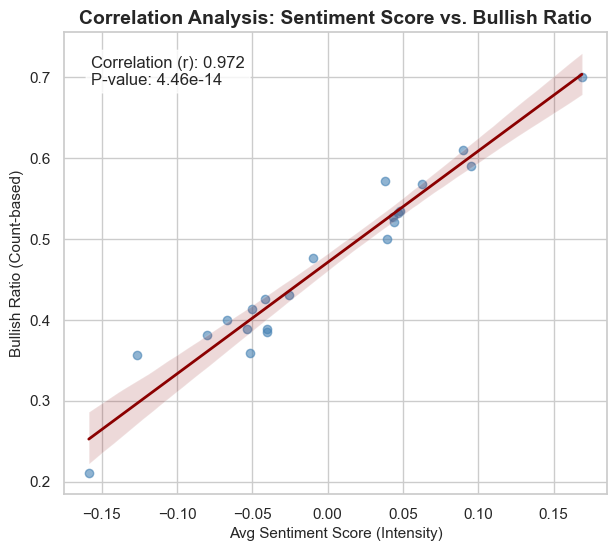

圖表已儲存至: plots/sentiment_correlation_check.png
兩者相關係數為: 0.9722
結論: ✅ 高度相關，兩者所含資訊量幾乎相同，擇一使用合理。


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 設定儲存路徑 ---
import os
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. 準備數據 (移除空值以避免報錯)
df_plot = df_final_signal[['Avg_Sentiment', 'Bullish_Ratio']].dropna()

# 2. 計算相關係數 (Pearson Correlation)
corr_coef, p_value = stats.pearsonr(df_plot['Avg_Sentiment'], df_plot['Bullish_Ratio'])

# 3. 繪圖
plt.figure(figsize=(7, 6))
sns.set_theme(style="whitegrid")

# 使用 regplot 繪製散佈圖 + 回歸線
# scatter_kws={'alpha':0.5}: 讓點半透明，方便觀察重疊度
# line_kws={'color': 'red'}: 回歸線設為紅色
ax = sns.regplot(x='Avg_Sentiment', y='Bullish_Ratio', data=df_plot, 
                 scatter_kws={'alpha': 0.6, 'color': 'steelblue'}, 
                 line_kws={'color': 'darkred', 'linewidth': 2})

# 4. 加上文字標註 (相關係數)
# 放在圖的左上角 (transform=ax.transAxes)
text_str = f'Correlation (r): {corr_coef:.3f}\nP-value: {p_value:.2e}'
plt.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. 設定標題與標籤
plt.title('Correlation Analysis: Sentiment Score vs. Bullish Ratio', fontsize=14, weight='bold')
plt.xlabel('Avg Sentiment Score (Intensity)', fontsize=11)
plt.ylabel('Bullish Ratio (Count-based)', fontsize=11)

# 6. 儲存圖片
save_path = f"{output_dir}/sentiment_correlation_check.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"圖表已儲存至: {save_path}")
print(f"兩者相關係數為: {corr_coef:.4f}")

if abs(corr_coef) > 0.8:
    print("結論: ✅ 高度相關，兩者所含資訊量幾乎相同，擇一使用合理。")
else:
    print("結論: ⚠️ 相關性未達極高標準，兩者可能包含不同面向的資訊 (例如強度 vs 頻率)。")

In [71]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import os

# 1. 設定標的清單
tickers = {
    'NASDAQ-100 (QQQ)': 'QQQ',
    'Dow Jones (DIA)': 'DIA',
    'Small Cap (IWM)': 'IWM',
    'S&P 500 (SPY)': 'SPY'  # 修正: SAP 是個股，SPY 才是大盤 ETF
}


# 用來儲存結果摘要
summary_list = []

if df_final_signal.index.tz is not None:

    df_final_signal.index = df_final_signal.index.tz_localize(None)

for name, ticker in tickers.items():
    print(f"\n--- 正在分析: {name} ---")

    # 1. 下載數據
    try:
        # 多抓幾天以免 shift 後數據不夠
        df_market = yf.download(ticker, start="2025-10-25", end="2025-12-16", progress=False, auto_adjust=True)
    except Exception as e:
        print(f"下載失敗: {e}")
        continue

    if isinstance(df_market.columns, pd.MultiIndex):
        df_market.columns = df_market.columns.get_level_values(0)

    df_market.index = pd.to_datetime(df_market.index).tz_localize(None)

    # 2. 計算特徵
    # Log Return
    df_market['Return'] = np.log(df_market['Close'] / df_market['Close'].shift(1)) * 100

    # [關鍵修正] Dynamic Terms: 昨天的報酬率
    df_market['Lag_Return'] = df_market['Return'].shift(1)

    # [關鍵修正] Target: 當日是否上漲 (這是我們要預測的 Y_t)
    df_market['Target_Up'] = (df_market['Return'] > 0).astype(int)

    # 3. 合併情緒資料
    # 注意：這裡假設 df_final_signal 已經是 "Trade_Date" 的數據
    # 如果您的情緒分數是 "盤後" 產生的，那您應該用 shift(1) 的情緒來預測今天的 Target
    # 這裡我們示範：用 "T-1 的情緒" 和 "T-1 的報酬" 預測 "T 的漲跌"

    # 先將情緒資料 shift(1)，代表「昨日情緒」
    df_sentiment_lagged = df_final_signal[['Avg_Sentiment', 'Std_Sentiment', "Bullish_Ratio"]].shift(1)
    df_sentiment_lagged.columns = [f'Lag_{c}' for c in df_sentiment_lagged.columns]

    df_reg = pd.merge(
        df_market[['Target_Up', 'Lag_Return']],
        df_sentiment_lagged,
        left_index=True,
        right_index=True,
        how='inner'
    )

    # 移除因 shift 產生的 NaN
    df_reg.dropna(inplace=True)

    if len(df_reg) < 10:
        print(f"⚠️ 樣本數過少 (N={len(df_reg)})，跳過")
        continue

    # 4. 設定模型 (Dynamic Logit)
    # 預測模型: P(Up_t) = f(Sentiment_{t-1}, Return_{t-1})
    X_cols = ['Lag_Avg_Sentiment', 'Lag_Std_Sentiment', 'Lag_Return']
    X = df_reg[X_cols]
    Y = df_reg['Target_Up']
    X = sm.add_constant(X)

    try:
        # 建立 Logit 模型
        model = sm.Logit(Y, X).fit(disp=0)

        # 預測與評估
        predictions_prob = model.predict(X)
        predictions_class = (predictions_prob > 0.5).astype(int)
        acc = accuracy_score(Y, predictions_class)
        baseline_acc = max(Y.mean(), 1 - Y.mean())

        print(f"樣本數: {len(df_reg)}")
        print(f"模型準確率: {acc:.2%} (Baseline: {baseline_acc:.2%})")
        print(f"Pseudo R2: {model.prsquared:.4f}")

        # 檢查變數顯著性
        print("--- 變數係數與 P-value ---")
        print(model.summary2().tables[1][['Coef.', 'P>|z|']])

        # 儲存摘要
        summary_list.append({
            'Asset': name,
            'Accuracy': f"{acc:.2%}",
            'Win_Baseline': acc > baseline_acc,
            'Sentiment_Pval': model.pvalues.get('Lag_Avg_Sentiment', 1.0),
            'Dynamic_Pval': model.pvalues.get('Lag_Return', 1.0), # 檢查動態項是否顯著
            'Pseudo_R2': model.prsquared
        })

    except Exception as e:
        print(f"Error: {e}")
        
print("\n====== Dynamic Logit 結果摘要 ======")
print(pd.DataFrame(summary_list))



--- 正在分析: NASDAQ-100 (QQQ) ---
樣本數: 20
模型準確率: 65.00% (Baseline: 55.00%)
Pseudo R2: 0.1638
--- 變數係數與 P-value ---
                       Coef.     P>|z|
const               7.170066  0.368864
Lag_Avg_Sentiment  14.607192  0.091272
Lag_Std_Sentiment -12.223077  0.384330
Lag_Return          0.457081  0.380761

--- 正在分析: Dow Jones (DIA) ---
樣本數: 20
模型準確率: 60.00% (Baseline: 55.00%)
Pseudo R2: 0.1104
--- 變數係數與 P-value ---
                       Coef.     P>|z|
const               8.129270  0.257585
Lag_Avg_Sentiment   9.057526  0.197220
Lag_Std_Sentiment -14.146353  0.267226
Lag_Return          0.326456  0.595252

--- 正在分析: Small Cap (IWM) ---
樣本數: 20
模型準確率: 60.00% (Baseline: 60.00%)
Pseudo R2: 0.1320
--- 變數係數與 P-value ---
                       Coef.     P>|z|
const               9.669589  0.191347
Lag_Avg_Sentiment   7.992473  0.280816
Lag_Std_Sentiment -16.664711  0.204980
Lag_Return          0.401833  0.321075

--- 正在分析: S&P 500 (SPY) ---
樣本數: 20
模型準確率: 65.00% (Baseline: 60.00%)
Pseudo R

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns


# --- 設定儲存路徑 ---
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 假設 df_final_signal 已經存在於你的環境中
if 'df_final_signal' in locals() and df_final_signal.index.tz is not None:
    df_final_signal.index = df_final_signal.index.tz_localize(None)

# --- 繪圖函數定義 ---
def save_heatmap_critique(cm, asset_name, accuracy, precision, specificity):
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = [f"{value:0.0f}" for value in cm.flatten()]
    
    # 避免分母為 0
    total = np.sum(cm)
    if total == 0: total = 1
    group_percentages = [f"{value:.2%}" for value in cm.flatten()/total]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, 
                xticklabels=['Pred Down', 'Pred Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    
    plt.title(f'{asset_name}\nAcc: {accuracy} | Prec: {precision} | Spec: {specificity}', fontsize=14, weight='bold')
    plt.ylabel('Actual Market Direction')
    plt.xlabel('Model Prediction')
    
    filename = f"{output_dir}/heatmap_{asset_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"  [圖片] 熱力圖已儲存: {filename}")

def color_red_green(val):
    """表格樣式：數值 > 0 綠色, < 0 紅色"""
    if pd.isna(val): return ''
    color = 'green' if val > 0 else 'red' if val < 0 else 'gray'
    return f'color: {color}; font-weight: bold;'

# --- 主程式 ---
tickers = {
    'NASDAQ-100 (QQQ)': 'QQQ',
    'Dow Jones (DIA)': 'DIA',
    'Small Cap (IWM)': 'IWM',
    'S&P 500 (SPY)': 'SPY'
}

for name, ticker in tickers.items():
    print(f"\n--- 正在分析並生成圖表: {name} ---")

    # 1. 下載數據
    try:
        df_market = yf.download(ticker, start="2025-10-25", end="2025-12-16", progress=False, auto_adjust=True)
    except Exception as e:
        print(f"  [錯誤] 下載失敗: {e}")
        continue

    if isinstance(df_market.columns, pd.MultiIndex):
        df_market.columns = df_market.columns.get_level_values(0)

    df_market.index = pd.to_datetime(df_market.index).tz_localize(None)

    # 2. 計算特徵 (為了表格顯示，這裡我們計算百分比 Return_Pct)
    df_market['Return_Pct'] = (df_market['Close'] / df_market['Close'].shift(1) - 1) * 100
    df_market['Lag_Return_Pct'] = df_market['Return_Pct'].shift(1) # 用於模型
    
    # Target: 1 = Up, 0 = Down
    df_market['Target_Up'] = (df_market['Return_Pct'] > 0).astype(int)

    # 3. 合併情緒資料
    if 'df_final_signal' not in locals():
        print("  [跳過] 找不到 df_final_signal 變數")
        break

    df_sentiment_lagged = df_final_signal[['Avg_Sentiment', 'Std_Sentiment']].shift(1)
    df_sentiment_lagged.columns = [f'Lag_{c}' for c in df_sentiment_lagged.columns]

    # 保留 Return_Pct 用於最後的表格展示
    df_reg = pd.merge(
        df_market[['Target_Up', 'Lag_Return_Pct', 'Return_Pct']], 
        df_sentiment_lagged,
        left_index=True, right_index=True, how='inner'
    )
    df_reg.dropna(inplace=True)

    if len(df_reg) < 10:
        print(f"  [跳過] 樣本數過少 (N={len(df_reg)})")
        continue

    # 4. 執行模型與生成 Confusion Matrix 圖片
    try:
        X = sm.add_constant(df_reg[['Lag_Avg_Sentiment', 'Lag_Std_Sentiment', 'Lag_Return_Pct']])
        Y = df_reg['Target_Up']
        
        # 靜音模式執行 Logit
        model = sm.Logit(Y, X).fit(disp=0)
        
        # 預測
        preds = (model.predict(X) > 0.5).astype(int)
        
        # 計算指標
        cm = confusion_matrix(Y, preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        
        acc = accuracy_score(Y, preds)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # 生成圖片 A: Confusion Matrix Heatmap
        save_heatmap_critique(
            cm, name, 
            f"{acc:.1%}", f"{precision:.1%}", f"{specificity:.1%}"
        )

    except Exception as e:
        print(f"  [錯誤] 模型計算失敗: {e}")
        continue

    # 5. 生成圖片 B: 每日成果追蹤表
    try:
        # 選取要展示的欄位
        df_display = df_reg[['Lag_Avg_Sentiment', 'Return_Pct']].copy()
        df_display.columns = ['Sentiment (T-1)', 'Return % (T)']
        
        # 取最近 15 天並套用樣式
        styled_df = (df_display.tail(20).style
            .format("{:+.2f}")
            .format("{:+.2f}%")
            .applymap(color_red_green)
            .set_caption(f"Daily Result: {name}")
            .set_table_styles([
                {'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px'), ('font-weight', 'bold')]},
                {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', 'black'), ('text-align', 'center')]}
            ])
        )
        
        # 匯出圖片
        safe_name = name.replace(' ', '_').replace('(', '').replace(')', '')
        image_path = f"{output_dir}/daily_result_{safe_name}.png"
        dfi.export(styled_df, image_path, table_conversion='matplotlib')
        print(f"  [圖片] 每日報表已儲存: {image_path}")

    except Exception as e:
        print(f"  [錯誤] 表格圖片生成失敗: {e}")


--- 正在分析並生成圖表: NASDAQ-100 (QQQ) ---
  [圖片] 熱力圖已儲存: plots/heatmap_NASDAQ-100 (QQQ).png


C:\Users\a5217\AppData\Local\Temp\ipykernel_10064\1827779714.py:149: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_red_green)


  [圖片] 每日報表已儲存: plots/daily_result_NASDAQ-100_QQQ.png

--- 正在分析並生成圖表: Dow Jones (DIA) ---
  [圖片] 熱力圖已儲存: plots/heatmap_Dow Jones (DIA).png


C:\Users\a5217\AppData\Local\Temp\ipykernel_10064\1827779714.py:149: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_red_green)


  [圖片] 每日報表已儲存: plots/daily_result_Dow_Jones_DIA.png

--- 正在分析並生成圖表: Small Cap (IWM) ---
  [圖片] 熱力圖已儲存: plots/heatmap_Small Cap (IWM).png


C:\Users\a5217\AppData\Local\Temp\ipykernel_10064\1827779714.py:149: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_red_green)


  [圖片] 每日報表已儲存: plots/daily_result_Small_Cap_IWM.png

--- 正在分析並生成圖表: S&P 500 (SPY) ---
  [圖片] 熱力圖已儲存: plots/heatmap_S&P 500 (SPY).png
  [圖片] 每日報表已儲存: plots/daily_result_S&P_500_SPY.png


C:\Users\a5217\AppData\Local\Temp\ipykernel_10064\1827779714.py:149: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_red_green)
